# LECT 1 : MNIST Classifier

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# LECT 2 : using COLAB

# LECT 3 : UNET

## 3.0. Basics

### 3.0.1. PIL.Image쓰기, nframes

https://ddolcat.tistory.com/690
여기서 PIL에 대해서 알 수 있다


512 x 512 x 30 의 video이고, 그중 24개를 train, 3개 3개를 val, test로 쓰겠다

<br>

QUESTION : 
* ASK: n_frames : kinda like the nubmer of frames in a video?

PIL.Image의 frame에 관한 설명 : 밑에 있다 (https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.seek)

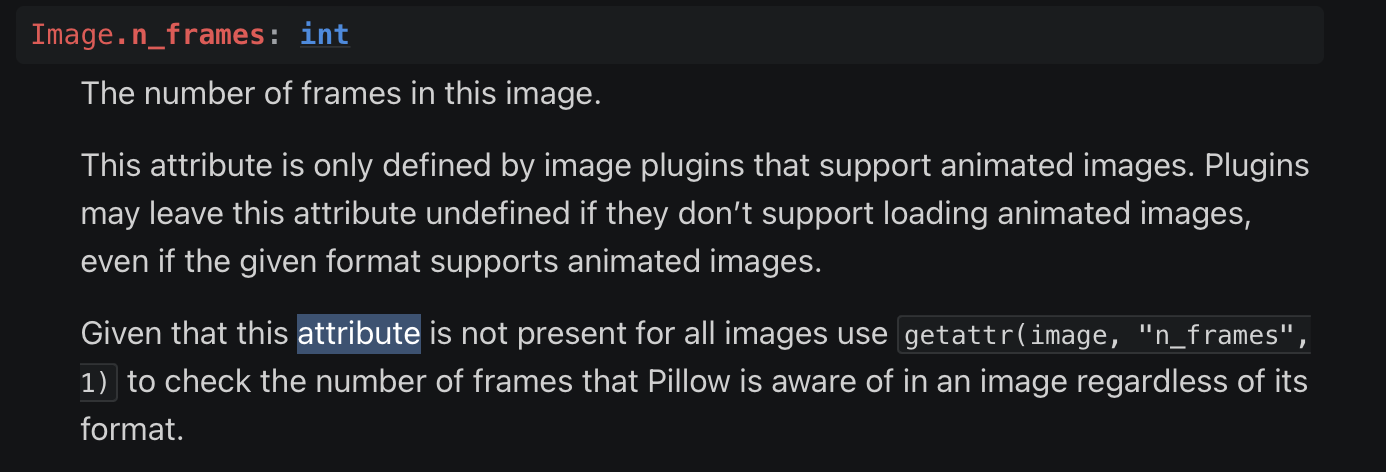
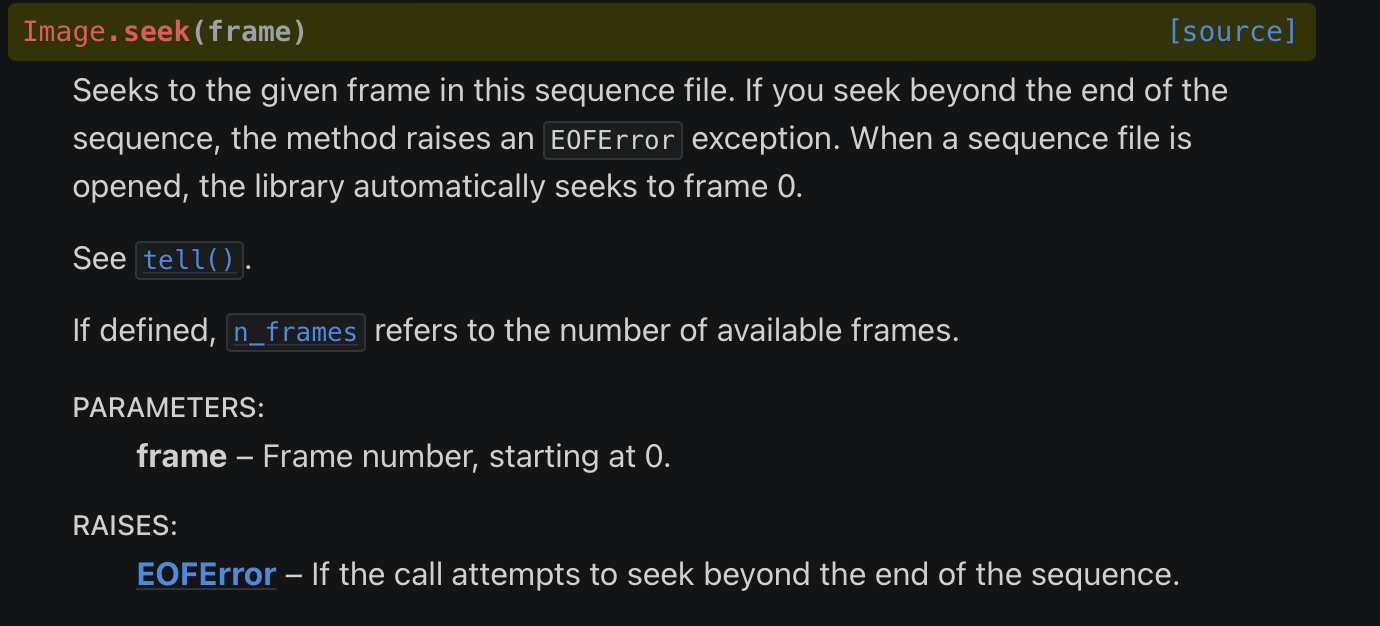

img.size, img.n_frames :  (512, 512) 30
[[126 107 122 ... 161 164 177]
 [138 118 123 ... 153 149 153]
 [141 135 145 ... 144 145 137]
 ...
 [155 149 168 ... 139 115 120]
 [163 154 166 ... 158 141 148]
 [151 141 160 ... 183 164 171]]


<function matplotlib.pyplot.show(*args, **kw)>

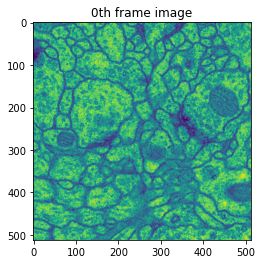

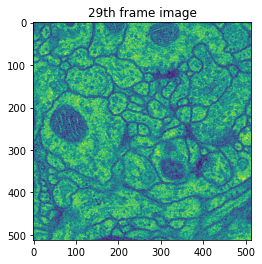

<Figure size 432x288 with 0 Axes>

In [2]:
#PIL.Image 가지고 노는 예시
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch


img = Image.open('./datasets/train-volume.tif')


print("img.size, img.n_frames : ", img.size, img.n_frames)

##numpy로 만들기 : np.array()쓰면 됨
print(np.array(img))

##같은 img_input이어도, 어떤 frame을 보느냐에 따라, 이미지가 다름
#어떤 frame 볼지 정하는 방법 : `img_input.seek(0)`
img.seek(0)
plt.title("0th frame image")
plt.imshow(img)
plt.figure()
plt.show

img.seek(29)
plt.title("29th frame image")
plt.imshow(img)
plt.figure()
plt.show



250
2


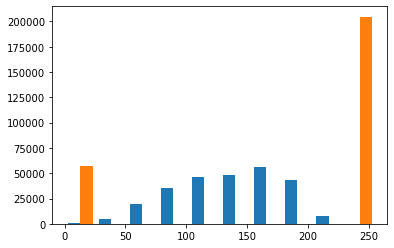

In [3]:
img_input = Image.open('./datasets/train-volume.tif')
img_label = Image.open('./datasets/train-labels.tif')

label_arr = np.array(img_label)
img_arr = np.array(img_input)
plt.hist([img_arr.flatten(), label_arr.flatten()], bins = 10)

#i.e. 0~255 의 8bit range 값을 가진다
print(len(np.unique(img_arr)))    #즉, input 은 0~255사이의 값을 가짐
print (len(np.unique(label_arr))) #즉, label은 0,1 두가지만 있다(label이니)

### 3.0.2. `__call__` method 쓰기


https://wjunsea.tistory.com/61 
이것을 보면 됨 (생략)

### 3.0.3. `lambda` function
(딴데다가 정리했으니 여기다가는 간단하게만 정리)

In [4]:
fn = lambda x: x**2
print(fn(10))
print(fn(3))

100
9


## 3.0.3. `ndarray` $\leftrightarrow{}$ `tensor` 왔다갔다 하는 것 관련된 것 



https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
여기를 보기! (여기를 보고 밑에 것들과 등등을 적음)


| numpy array|torch tensor 	| 
|---	|---	|
| only data(array) | data(array) + computational graph 	| 


* `ndarray` $\rightarrow{}$ `torch.tensor` : computational graph를 detach 시킨후 (using `.detach()`, numpy로 바꿔야한다!! (그래야 error이 안뜸)
> `some_tesnor.detach().numpy()` 로 해야함!

* `torch.tensor` $\rightarrow{}$ `ndarray` :
> `torch.from_numpy`를 쓰기


> 저런식으로 하면, `ndarray` and `tensor`이 shares the same memory 라고함!! 

## Question :
detach() 해도, shared memory라서 same memory location 에 존재한다고 했는데, 이게 VRAM/CPU RAM간에도 똑같이 값들이 보존이 되나요? (맥북은 RAM이 cpu/gpu 통합이라 device바꿔도 차이가 없는 것 같아, cuda일떄는 어떻게 되는지 궁금합니당!


In [5]:
a = torch.rand((2,2), requires_grad = True)

print(a) #tensor, with computational graph
print(a.detach()) #tensor, but with NO computational graph
print(type(a.detach().numpy()),'\n',a.detach().numpy()) #just a numpy
print(type(a.numpy())) #즉, 에러가 뜸! 왜냐하면 computational graph를 때지 않고 했기 때문!
#as expected, `requires_grad = False`인 tensor은 바로 .numpy()해도 에러가 안뜸 (애초에 computational graph가 없었으니)

tensor([[0.5534, 0.9267],
        [0.2056, 0.2501]], requires_grad=True)
tensor([[0.5534, 0.9267],
        [0.2056, 0.2501]])
<class 'numpy.ndarray'> 
 [[0.5534348  0.92674077]
 [0.2055527  0.25008583]]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

## 3.1. Image 불러오기/.npy로 frame별로 저장하기

### 3.1.1. Image불러오기
(여기서 쓰인 Image에 대한 것들은 위의 Supplemental보기)

In [3]:
#import packages
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

##데이터 불러오기
dir_data = './datasets'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size #dimensions, PIL.Image의 attribute중 하나
nframe = img_label.n_frames

#set how many frames to use as train/val/test
nframe_train = 24
nframe_val = 3
nframe_test = 3

#print(img_label.shape)
#plt.imshow(img_input)

### 3.1.2. Image 를 frame별로 ndarray로 바꿔서 train/test/split해서 저장해주기

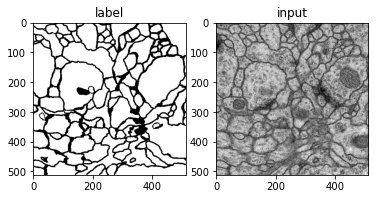

In [4]:
##저장 디렉토리 설정하고 그 디렉토리들을 만들어주기
dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train): #trainig set dir 만들기
    os.makedirs(dir_save_train)

if not os.path.exists(dir_save_val): #validation set dir 만들기
    os.makedirs(dir_save_val)

if not os.path.exists(dir_save_test): #testing set dir 만들기
    os.makedirs(dir_save_test)

##random train/test split을 하고 array 로 해서 frame별로 저장하기
id_frame = np.arange(nframe) 
np.random.shuffle(id_frame) #i.e. frame shuffling

offset_nframe = 0 #initialize
for i in range(nframe_train): #i.e. 24개를 한다
    #어떤 frame을 볼지 지정
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])
    
    #그 frame의 labe,input img를 array 화 시키기
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val, 'input_%03d.npy' % i), input_)

##
offset_nframe = nframe_train + nframe_val #즉, 전의 것에서 추가된 그 frame부터 본다

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test, 'input_%03d.npy' % i), input_)

    
##결과 몇개 보기 
plt.subplot(121)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(122)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()
  

## 3.2. UNET 모델 만들기

In [5]:
## 3.2.1. import packages and setup initialization 

In [7]:
##package가져오기 
import argparse

import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter #없어서 일딴 뺌

#from model import UNet
#from dataset import *
#from util import *

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

##model hyperparams 하기
lr = 1e-3
batch_size = 2
num_epoch = 10

data_dir = './datasets/'
ckpt_dir = './checkpoint'
log_dir = './log'


device = torch.device('mps' if torch.backends.mps.is_available() else "cpu")
print(device)

mps


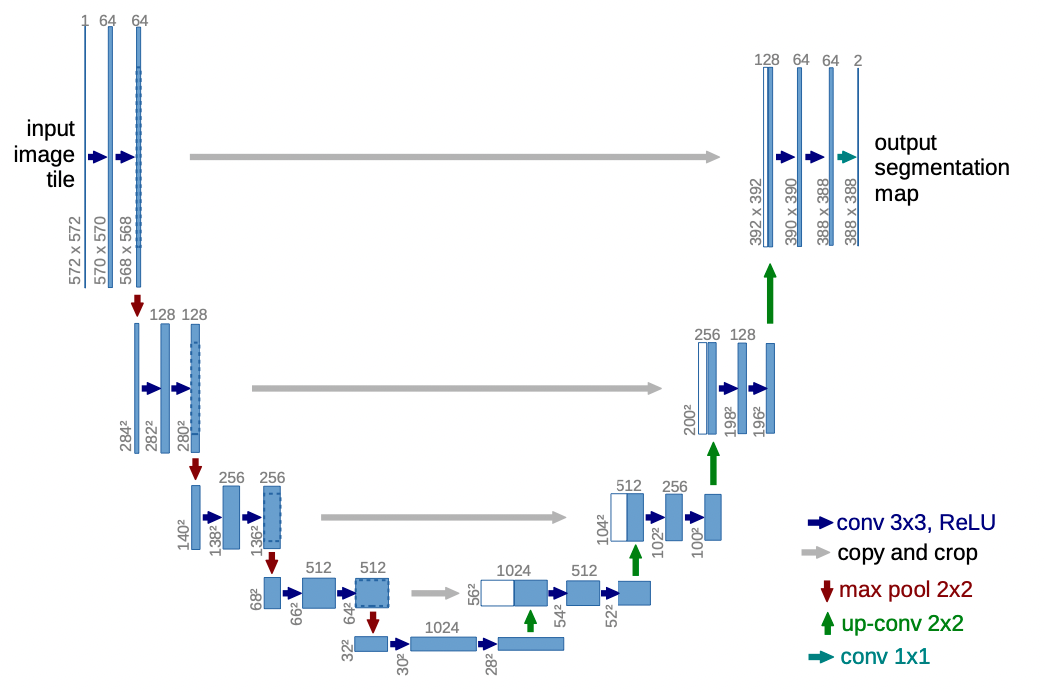
사실 위에서 conv2d RELU,적혀있찌만 batchnorm도 한다

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        #위에서 파란색 화살표 보면 알 수 있듯이,파란색 화살표 : conv 3x3, ReLU , batchnorm(이것도 원래 하는데 안적혀있음) 한다. 따라서, 셋을 한방에 하는 함수를 저으이하자
        def CBR2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding =1 , bias = True):
            #MNIST 예시에서 했던 것처럼, list of layers한 후에 sequential 안에 kargs 로 넣어주기
            layers = []
            #CBR2d에서 input으로 받는 것들을 내가 사용해서 밑에 layers list만들기
            layers += [nn.Conv2d(in_channels = in_channels, out_channels= out_channels, 
                                kernel_size= kernel_size, stride= stride, padding= padding, bias= bias)] #이것은 list.append()로 할 수도 있으나, 이렇게 해도 된다
            layers += [nn.BatchNorm2d(num_features = out_channels)] #num_features : channel갯수를 의미 ([N, C, H, W])
            layers += [nn.ReLU()]
            
            cbr = nn.Sequential(*layers)#layer내의 것들을 nn.Sequential로 묶기 #remember *args removes the [] 
            return cbr
            
        #이제 CBR2d하나로, 위 그림에 나오는 feature size 그 말해주는 것에 맞춰서 하자 
        #enc1_1 : 첫번째 thing 의 첫번째 encoding        
        
        ##encoder (화살표들을 구현하는 것!)
        self.enc1_1 = CBR2d(in_channels= 1, out_channels=64) #첫번째 파란색 화살표 구현
        self.enc1_2 = CBR2d(in_channels= 64, out_channels=64) #두번째 파란색 화살표 구현
        
        self.pool1 = nn.MaxPool2d(kernel_size= 2) #첫번째 빨간색 화살표 구현 (2x2라 했으니 2로 함)
        
        self.enc2_1 = CBR2d(in_channels= 64, out_channels=128) #뭔지 설명은 생략
        self.enc2_2 = CBR2d(in_channels= 128, out_channels=128)
        
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.enc3_1 = CBR2d(in_channels= 128, out_channels=256) #뭔지 설명은 생략
        self.enc3_2 = CBR2d(in_channels= 256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.enc4_1 = CBR2d(in_channels= 256, out_channels=512) #뭔지 설명은 생략
        self.enc4_2 = CBR2d(in_channels= 512, out_channels=512)
    
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        self.enc5_1 = CBR2d(in_channels= 512, out_channels=1024) #뭔지 설명은 생략
        
        ##Expansive path/deconvolution
        self.dec5_1 = CBR2d(in_channels= 1024, out_channels=512)
        
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,kernel_size=2, stride=2, padding=0, bias=True)#unconvolution
        
        #여기서 두개를 합해줘야함 (enc4_3을 합쳐줘야함... 근데 이것은 나중에 한다 (여기서는 함수만 정의함))
        #decoding은 대칭을 만들어서 거꾸로 가게하기!
        self.dec4_2 = CBR2d(in_channels=512*2, out_channels=512) #*2 becasue concatenation
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)
        
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec3_2 = CBR2d(in_channels=256*2, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)
        
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec2_2 = CBR2d(in_channels=128*2, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)
        
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)
        
        self.dec1_2 = CBR2d(in_channels=64*2, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)
        
        #2로 channel수를 줄여주기 위해서  1x1 convolution을 한다!
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        
    #실제로 forward propagation정의하자
    def forward(self,x):
        #원래느 x= x= 이런식으로하는데 여기서 그렇게 하지 않는 이유 => 나중에 copy and crop을 해야하기 때문에!!
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)
        
        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool1(enc2_2)
    
        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool1(enc3_2)
        
        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool1(enc4_2)
        
        enc5_1 = self.enc5_1(pool4)
        
        #decoding part
        dec5_1 = self.dec5_1(enc5_1)
        
        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim = 1) #i.e. concatenation along the channel dimension (remember, (B, C, H, W이다))
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)
        
        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)       
        
        result = self.fc(dec1_1)
        
        return result
        

In [9]:
a = UNet()
print(a)

UNet(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [12]:
#from torchsummary import summary 
import torchinfo

ModuleNotFoundError: No module named 'torchinfo'

## 3.3 (?) DataLoader & Transform 구현하기 (뭔가 이게 3.2여야 할듯...?)

* `Dataset` : `__getitem__`해서, indexable하게 만들기 => 3.3.1
    * `trasnform`을 dataset정의할때 만들어서 넣어주기: transformation을 하나로 하기 => 3.3.2
        * image normalization 
        * image random flip하기
        * `ndarray` $\rightarrow{}$ `torch.tensor` 로 바꾸기 (numpy 는 (H,W,C) => torch는 (C, H, W)로 transpose도 해야한다)
        * use `transform.Compose()` to add these all together
* `DataLoader` : `Dataset`을 batch 로 model에서 사용되도록 하기 => 3.3.3

### 3.3.1. `Dataset` 정의하기
* `__len__`
* `__getitem__`

을 정의 해야한다! (그렇게 해야 dataloading에서 그 method들을 사용해서 dataloading 시 사용)

#### QUESTION : ASK ASK ASK 
참고로,
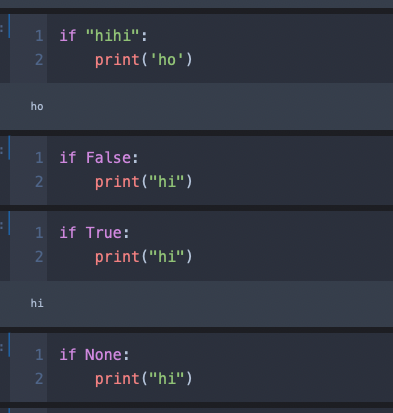

즉, `False`, `None`만 아니면 if 문 작동??

In [12]:
##DATASET (Dataset이라는 것 정의) (custom dataset)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform = None):
        self.data_dir = data_dir
        self.transform = transform
        
        lst_data = os.listdir(self.data_dir)
        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]
        
        lst_label.sort()
        lst_input.sort()
        
        self.lst_label = lst_label
        self.lst_input = lst_input        
    
    def __len__(self): #total number of samples, both label and input 합쳐서
        return len(self.lst_label)
    
    def __getitem__(self, index): #[]하면 가져올 수 있도록 만들기
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        
        label = label/255.0 #0~1 scaling
        input = input/255.0
        
        
        #channel 도 1로 dimensino을 넣어줘야해서, 강제로 new axis로 축 하나 더 끼우기
        if label.ndim == 2:
            label = label[:,:,np.newaxis]
        if input.ndim ==2:
            input = input[:,:,np.newaxis]
        
        #data는 dictionary로 하기
        data = {'input' : input, 'label': label}
        
        if self.transform : #i.e. if not none, perform the trasnformation a
            data = self.transform(data)
        
        return data #i.e. return the data, which is the dictionary

### 3.3.2. `Dataset`에 사용할 transformation정의하기

`transformation`에서 해야할 만한 것 :

1. `numpy : (H, W, C)` $\rightarrow{}$ `torch : (C, H, W)` 로 바꿔야함! (그 후 dataloading까지 하면 (N, C, H, W)가 됨)
2. `ndarray` => `torch.tensor`로 바꿔야함 
3. normalization하기 (stdev, mean으로 normalize하기)
4. RandomFlip하기 (part of data augmentation I guess)
5. `transforms.Compose` 로 합치기


## Question:
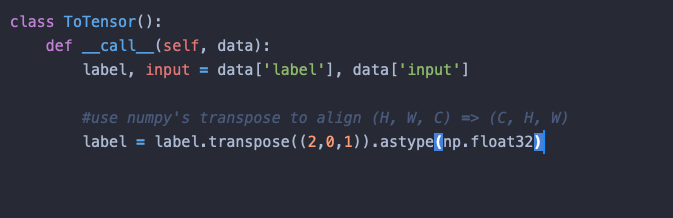
why float 32 in particular?


## Question
is using `input` a good convention?

## Questinon:
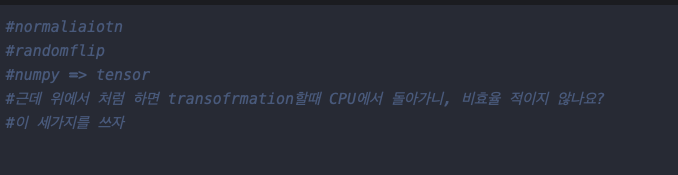
(since numpy : on cpu)

## Questyion:
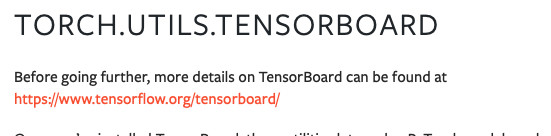
tensorflow 에서 만든 것인데.. part of the package in torch..? what?


In [13]:
#all transformations : data (dict) => data(dict) 행태로 감!! (transformation은 그냥 dict자체는 안건드리고 안에있는 내용만 건드려야 하니)
class Normalization(): #normalize to given mean/std
    def __init__(self, mean = 0.5, std = 0.5):
        self.mean = mean
        self.std = std
    
    def __call__(self, data): #data. dictionary of the type we get from calss ToTensor thing above
        label, input = data['label'], data['input']
        input = (input - self.mean)/self.std    #label will not be normalized (cuz it's an image with pixel values of only 0 or 1)
        data = {'input': input, 'label': label} #또다시, dict형태로 return 하기
        return data

class RandomFlip(): #randomly flip the x or y axis
    def __call__(self,data):
        label, input = data['label'], data['input']
        
        if np.random.rand()> 0.5 : #i.e. in half the time, flip left and right (only works becuase it's shaped (H,W,C), not (C, H, W))
            label = np.fliplr(label)
            input = np.fliplr(input)
        
        if np.random.rand()>0.5 :  #note : elif가 아닌 그냥 if 이다 => 따라서 어쩌면 LR, UD flip두개 다 된 상태일 수도 있다
            label = np.flipud(label)
            input = np.flipud(input)
        
        data = {'label': label, 'input':input}
        return data

class ToTensor():
    def __call__(self, data):
        label, input = data['label'], data['input']
        
        #use numpy's transpose to align (H, W, C) => (C, H, W)
        label = label.transpose((2,0,1)).astype(np.float32)
        input = input.transpose((2,0,1)).astype(np.float32)
        
        #change numpy to torch.tensor
        data = {'input': torch.from_numpy(input), 'label': torch.from_numpy(label)}
        return data
        
#use the Compose method to add all of em together
#note : `__call__`을 쓴것들에만 가능하다!
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(),ToTensor()])

============BEFORE TRANSFORMATION=========
(512, 512, 1)
(512, 512, 1)


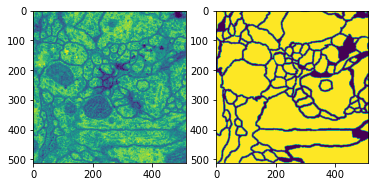

============AFTER TRANSFORMATION=========
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])


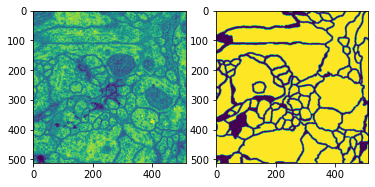

In [14]:
##looking at the actual results and plotting them)(before and after the transformation)
print("============BEFORE TRANSFORMATION=========")
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))
sample_data = dataset_train[0]  #i.e. first sample
print(sample_data['input'].shape)
print(sample_data['label'].shape)

plt.subplot(121)
plt.imshow(sample_data['input'].squeeze()) #squeeze because the extra channel dimension has to be removed

plt.subplot(122)
plt.imshow(sample_data['label'].squeeze()) #squeeze because the extra channel dimension has to be removed
plt.show()

print("============AFTER TRANSFORMATION=========")

dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'), transform = transform)
sample_data = dataset_train[0]  #i.e. first sample
#first sample의 input, label을 보자
print(sample_data['input'].shape)
print(sample_data['label'].shape)

plt.subplot(121)
plt.imshow(sample_data['input'].squeeze()) #squeeze because the extra channel dimension has to be removed

plt.subplot(122)
plt.imshow(sample_data['label'].squeeze()) #squeeze because the extra channel dimension has to be removed
plt.show()

위에서, we see that :
* shape chagned to (C,H,W)
* value changed (normalized) (not visible)
* was flipped randomly
* ndarray => tensor로 바뀜 (dtpye도 float32로 바뀌었을것)

### 3.3.3. DataLoader 만들기/qㅜㄹ러오기
앞에서 우리는 dataset을 정의했는데, 이것은 하나만 가져오는 것 => 따라서, dataloader로 여러개 가져오도록 하자

이미 pytorch에서 구현된 `DataLoader`을 그대로 가져다가 쓰고, batch size등등 다른 arugments만 맞춰주자

In [15]:
#다시한번 transform정의 (reminder)
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

#defining the train/validation dataset (using what we defiend previously)
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'),transform = transform)
dataset_val = Dataset(data_dir = os.path.join(data_dir, 'val'),transform = transform)

#now defining the dataloader using the dataset
loader_train= DataLoader(dataset_train, batch_size= batch_size, shuffle = True, num_workers = 0) 
loader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle=False, num_workers = 0)

# 4. 실제로 training시키기
이제, 위에서 model도 만들었고, DataLoader도 만들었으니, loss정의하고 optim정의하고 등등해서 실제로 training만 시키면 된다!

## 4.1. loss, optimizer,등등 정의하기

In [16]:
## create network
net = UNet().to(device)

##define loss function (what we want to optimizer)
fn_loss = nn.BCEWithLogitsLoss().to(device) #sigmoid layer + BCE Loss를 한꺼번에 하는 거래 #BCE loss : Binary corss entorpy loss 

##define the opitmizer
optim = torch.optim.Adam(net.parameters(), lr = lr) #network의 paramters (`net.parameters`)를 update해줄 것이다

#그 밖에 부수적인 것들도 정의해주기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

#train/val할때 쓰이는 batch가 몇개일 지 숫자로 저장해놓자 
num_batch_train = np.ceil(num_data_train/batch_size) 
num_batch_val = np.ceil(num_data_val/batch_size)

#몇가지 쓰일 함수들도 labmda function방법으로 정의해두자
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0,2,3,1) 
            #여기서 detach의 의미 : 위에 supplementary인가 거기에서 적어놓음 (numpy array 로 하려면, 먼저 computational graph에서 detach시켜야 해서 이렇게 한것임)
            #transpose(0,2,3,1)을 한다 (이것은 numpy : ())
fn_denorm = lambda x, mean, std : (x*std)+mean #denorming thing
fn_class = lambda x : 1.0 *(x>0.5) 
    #binary class로 분류하는 function (remember, the label image was either 0 or 1)
    #i.e. 1 if larger than 0.5, 0 otherwise (True = 1, False = 0  이니)

#tensorboard용 다른 것들도 하기!
writer_train = SummaryWriter(log_dir = os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir = os.path.join(log_dir, 'val'))

## 4.2. CREATE TRAIN/TEST LOOP

ASK

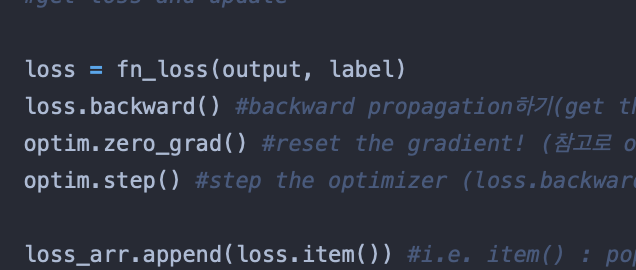
이러면 update잘 안되고

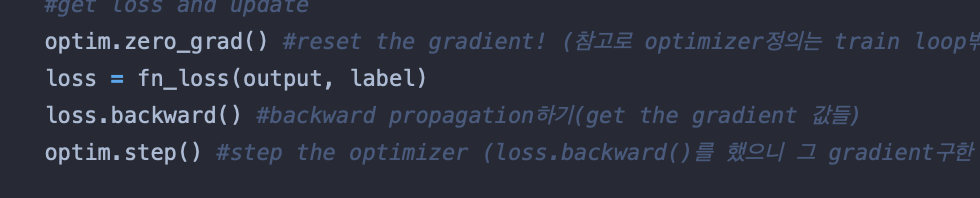

이러면 된다.. 두 ㄹ의 차이.,.?


In [36]:
st_epoch = 0 #start epoch

for epoch in range(st_epoch+1, num_epoch+1):
    ###training loop#######
    net.train() #CHANGE TO TRAINING MODE
    loss_arr = [] #keep track of the loss #one batch에 대한 것
    for batch, data in enumerate(loader_train, 1): #data : dict with keys 'input' and 'label'
        label = data['label'].to(device) #SEND TO DEVICE!
        input = data['input'].to(device)

        output = net(input) #i.e. forward pass

        #get loss and update
        optim.zero_grad() #reset the gradient! (참고로 optimizer정의는 train loop밖에서 이미 했었음)
        loss = fn_loss(output, label)
        loss.backward() #backward propagation하기(get the gradient 값들)
        optim.step() #step the optimizer (loss.backward()를 했으니 그 gradient구한 것으로 update 하기)
        
        loss_arr.append(loss.item()) #i.e. item() : pop the tensor out from the loss and use it
        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %(epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
        
        #Tensorboard에 저장하기 => tensor을 numpy 형태로 바꿔서 (dim shape도 바꿔서) 저장해야함!
        label = fn_tonumpy(label) 
        input = fn_tonumpy(fn_denorm(input, mean = 0.5, std = 0.5)) #i.e. denormalize해야지 oriignal input이 된다!
        output = fn_tonumpy(fn_class(output)) #i.e. 0,1값중 하나로 class하기 (boundary or not)
        
        writer_train.add_image('label', label, num_batch_train*(epoch-1)+batch, dataformats="NHWC") #즉, N, H, W, C의 axis shape로 들어간다! (like numpy)
        writer_train.add_image('input', input, num_batch_train*(epoch-1)+batch, dataformats="NHWC")
        writer_train.add_image('output', output, num_batch_train*(epoch-1)+batch, dataformats="NHWC") 
    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)
    
    ###testing loop##### => no_grad()해서 backprop안하도록 하기!
    with torch.no_grad():
        net.eval()  #network : evaluation mode로 전환!
        loss_arr = [] #testing loss
        
        for batch,data in enumerate(loader_val, 1):
            #forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)
            output = net(input)
            
            #get loss
            loss = fn_loss(label, output)
            
            #Tensorboard저장
            label = fn_tonumpy(label) 
            input = fn_tonumpy(fn_denorm(input, mean = 0.5, std = 0.5))
            output = fn_tonumpy(fn_class(output))
                                         
            writer_val.add_image('label', label, num_batch_val*(epoch-1)+batch, dataformats="NHWC") #즉, N, H, W, C의 axis shape로 들어간다! (like numpy)
            writer_val.add_image('input', input, num_batch_val*(epoch-1)+batch, dataformats="NHWC")
            writer_val.add_image('output', output, num_batch_val*(epoch-1)+batch, dataformats="NHWC")                             
        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)
writer_train.close() #close the writer
writer_val.close()

TRAIN: EPOCH 0001 / 0010 | BATCH 0001 / 0012 | LOSS 0.6163
TRAIN: EPOCH 0001 / 0010 | BATCH 0002 / 0012 | LOSS 0.5678
TRAIN: EPOCH 0001 / 0010 | BATCH 0003 / 0012 | LOSS 0.5332
TRAIN: EPOCH 0001 / 0010 | BATCH 0004 / 0012 | LOSS 0.5020
TRAIN: EPOCH 0001 / 0010 | BATCH 0005 / 0012 | LOSS 0.4827
TRAIN: EPOCH 0001 / 0010 | BATCH 0006 / 0012 | LOSS 0.4717
TRAIN: EPOCH 0001 / 0010 | BATCH 0007 / 0012 | LOSS 0.4590
TRAIN: EPOCH 0001 / 0010 | BATCH 0008 / 0012 | LOSS 0.4466
TRAIN: EPOCH 0001 / 0010 | BATCH 0009 / 0012 | LOSS 0.4364
TRAIN: EPOCH 0001 / 0010 | BATCH 0010 / 0012 | LOSS 0.4283
TRAIN: EPOCH 0001 / 0010 | BATCH 0011 / 0012 | LOSS 0.4197
TRAIN: EPOCH 0001 / 0010 | BATCH 0012 / 0012 | LOSS 0.4137
TRAIN: EPOCH 0002 / 0010 | BATCH 0001 / 0012 | LOSS 0.3247
TRAIN: EPOCH 0002 / 0010 | BATCH 0002 / 0012 | LOSS 0.3341
TRAIN: EPOCH 0002 / 0010 | BATCH 0003 / 0012 | LOSS 0.3284
TRAIN: EPOCH 0002 / 0010 | BATCH 0004 / 0012 | LOSS 0.3296
TRAIN: EPOCH 0002 / 0010 | BATCH 0005 / 0012 | LOSS 0.32

KeyboardInterrupt: 

In [1]:
lr

NameError: name 'lr' is not defined

In [ ]:
log_dir

In [2]:
print("HIHIHIHI")

HIHIHIHI


In [ ]:
a = torch.rand((1,2,3,4))
b= fn_tonumpy(a)

print(type(a))
print(a.shape)

print(type(b))
print(b.shape)

a = np.linspace(0,1,100)
plt.plot(a, fn_class(a))

In [ ]:
help(nn.BCEWithLogitsLoss)

In [ ]:
help(nn.BCELoss)

In [ ]:
os.listdir(os.path.join(data_dir,'train'))

In [ ]:
# i.e. use call only if data 에 하나만 해주면 되고 복잡한 것을 안해도 될때

In [ ]:
np.random.rand()

In [ ]:
##looking at the actual results and plotting them
dataset_train = Dataset(data_dir = os.path.join(data_dir, 'train'))

#first sample의 input, label을 보자
sample_data = dataset_train[0] #or, could also do dataset_train.__get__item(0)
print(sample_data['input'].shape)
print(sample_data['label'].shape)

plt.subplot(121)
plt.imshow(sample_data['input'].squeeze()) #squeeze because the extra channel dimension has to be removed

plt.subplot(122)
plt.imshow(sample_data['label'].squeeze()) #squeeze because the extra channel dimension has to be removed
plt.show()

In [ ]:
a = np.arange(9).reshape(1,3,3)
a

In [ ]:
print(np.fliplr(a))
print(np.flipud(a))

In [ ]:
#룩시드 랩스 답장! also more things!